# Hierarchical Models

In [10]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Math Test

In [11]:
math_df = pd.read_csv('Data/mathtest.csv')

In [12]:
mean_by_school = math_df.groupby('school').mean()
count_by_school = math_df.groupby('school').count()
school_group_count = len(count_by_school)
total_numof_data = len(math_df)
#aggregate_mean = data.values.mean(axis = 0)[1]
aggregate_mean = math_df.values.mean(axis = 0)[1]

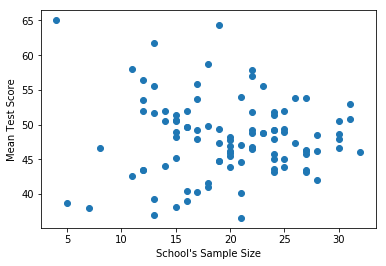

In [13]:
plt.scatter(count_by_school,mean_by_school)
plt.xlabel('School\'s Sample Size')
plt.ylabel('Mean Test Score')
plt.show()

We observe that the schools with fewer student data have higher variance
##### MCMC

Let us fit a normal hierarchical model to Mathtest dataset using Gibbs
Priors for unknown parameters are:
$$
\begin{aligned}\left(y_{i} | \theta_{i}, \sigma^{2}\right) & \sim N\left(\theta_{i}, \sigma^{2}\right) \\\left(\theta_{i} | \mu, \sigma^{2}, \tau^{2}\right) & \sim N\left(\mu, \sigma^{2} \tau^{2}\right) \\ \mu & \sim I_{\mathbb{R}}(\mu), \text { a flat prior} \\ \tau^{2} & \sim I_{\mathbb{R}^{+}}\left(\tau^{2}\right), \text { a flat prior} \\ \sigma^{2} & \sim\left(\frac{1}{\sigma^{2}}\right) I_{\mathbb{R}^{+}}\left(\sigma^{2}\right), \text { Jeffreys prior } \end{aligned}
$$

$$
\begin{aligned}\left(\theta_{i} | y, \mu, \sigma^{2}, \tau^{2}\right) & \sim N\left(m^{*}, v^{*}\right) \\ & \text { with } \\ v^{*} &=\left[\frac{n_{i}}{\sigma^{2}}+\frac{1}{\sigma^{2} \tau^{2}}\right]^{-1}=\left[\frac{n_{i} \tau^{2}+1}{\sigma^{2} \tau^{2}}\right]^{-1}=\sigma^{2}\left[\frac{\tau^{2}}{n_{i} \tau^{2}+1}\right] \\ m^{*} &=v^{*}\left[\left(\frac{n_{i}}{\sigma^{2}}\right) \overline{y}_{i}+\left(\frac{1}{\sigma^{2} \tau^{2}}\right) \mu\right] \end{aligned}
$$
$$
\begin{aligned}\left(\mu | \theta, y, \sigma^{2}, \tau^{2}\right) \sim N\left(\overline{\theta}_{i}, \frac{\sigma^{2} \tau^{2}}{p}\right)\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\; \; \;\end{aligned}
$$
$$
 \; \;\; \; \;\; \; \;\; \; \;\;\left(\sigma^{2} | \theta, y, \mu, \tau^{2}\right) \sim I G\left(\frac{(n+p)}{2},\left\{\frac{1}{2} \sum_{i=1}^{p} \sum_{j=1}^{n_{i}}\left(y_{i j}-\theta_{i}\right)^{2}+\frac{1}{2 \tau^{2}} \sum_{i=1}^{p}\left(\theta_{i}-\mu\right)^{2}\right\}\right)
$$
$$
\left(\tau^{2} | \theta, y, \mu, \sigma^{2}\right) \sim I G\left(\frac{p}{2}-1, \frac{1}{2 \sigma^{2}} \sum_{i=1}^{p}\left(\theta_{i}-\mu\right)^{2}\right)\; \;\; \; \;\; \; \;\; \; \;\;\; \;\; \; \;\; \; \;\; \; \;\;\; \;\; \; \;\;
$$

Initiations for Monte Carlo Sims

In [14]:
iterations = 10000
sigmasq = np.zeros(iterations+1)
tausq = np.zeros(iterations+1)
mu = np.zeros(iterations+1)
theta = np.zeros((school_group_count, iterations+1))
sigmasq[0] = 1
tausq[0] = 1
mu[0] = aggregate_mean
theta[:,0] = mean_by_school.values[:,0]

In [15]:
for i in range(iterations):
    vstar = (sigmasq[i]*tausq[i]) / (count_by_school.values*tausq[i] + 1)
    mstar = vstar * ( count_by_school.values*mean_by_school.values/sigmasq[i] + mu[i]/(sigmasq[i]*tausq[i]) )
    theta[:,i+1] = np.random.normal(mstar,vstar)[:,0]
    mu[i+1] = np.random.normal(np.mean(theta[:,i+1]),sigmasq[i]*tausq[i]/school_group_count)
    schoolindexes = math_df.values[:,0].astype(int) - 1
    sum1 = np.sum( np.square((math_df.values[:,1]-theta[schoolindexes,i+1])))
    sum2 = np.sum( np.square(theta[:,i+1] - mu[i+1]) )
    sigmasq[i+1] = 1 / np.random.gamma( (total_numof_data+school_group_count)/2 , 1/(0.5*(sum1 + sum2/tausq[i])) )
    tausq[i+1] = 1 / np.random.gamma( 0.5*school_group_count-1 , 1/(0.5*(sum2/sigmasq[i+1])) )

In [16]:
#Burn Beginning Observations
burn = 1000
theta = theta[:,burn:-1]
mu = mu[burn:-1]
sigmasq = sigmasq[burn:-1]
tausq = tausq[burn:-1]
#Thin the data
thin = 2
slicedindex = range(0,len(tausq),thin)
theta = theta[:,slicedindex]
mu = mu[slicedindex]
sigmasq = sigmasq[slicedindex]
tausq = tausq[slicedindex]

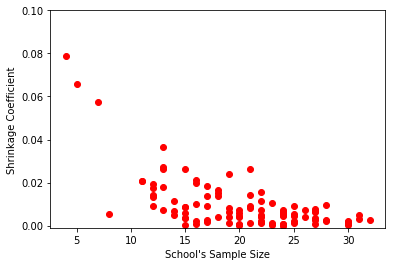

In [17]:
post_mean = np.mean(theta,1)
ki = abs((post_mean-mean_by_school.values[:,0])/mean_by_school.values[:,0])
x_ki = list(range(1,len(ki)+1))
plt.scatter(count_by_school.values[:,0],ki,c='r')
#plt.scatter([1],[5])
axes = plt.gca()
axes.set_ylim([-0.001,0.1])
plt.xlabel('School\'s Sample Size')
plt.ylabel('Shrinkage Coefficient')
plt.show()

### Price Elasticity of Demand

In [18]:
cheese_df = pd.read_csv('Data/cheese.csv')
cheese_df.head()

,store,price,vol,disp
0,LOS ANGELES - LUCKY,2.578460,21374,1
1,LOS ANGELES - RALPHS,3.727867,6427,1
2,LOS ANGELES - VONS,2.711421,17302,1
3,CHICAGO - DOMINICK,2.651206,13561,1
4,CHICAGO - JEWEL,1.986674,42774,1


In [19]:
cheese_df["log_vol"] = np.log(cheese_df['vol'])
cheese_df["log_price"] = np.log(cheese_df['price'])
cheese_df["disp_logprice"] = cheese_df['disp']*cheese_df['log_price']
cheese_df["ones"] = 1
cheese_df.head()

,store,price,vol,disp,log_vol,log_price,disp_logprice,ones
0,LOS ANGELES - LUCKY,2.578460,21374,1,9.969931,0.947192,0.947192,1
1,LOS ANGELES - RALPHS,3.727867,6427,1,8.768263,1.315836,1.315836,1
2,LOS ANGELES - VONS,2.711421,17302,1,9.758577,0.997473,0.997473,1
3,CHICAGO - DOMINICK,2.651206,13561,1,9.514953,0.975015,0.975015,1
4,CHICAGO - JEWEL,1.986674,42774,1,10.663686,0.686462,0.686462,1


Fit a Linear Regression Model to each store

In [20]:
unique_stores = pd.unique(cheese_df['store'])
y_df = cheese_df[['store', 'log_vol']]
X_df = cheese_df[['store', 'ones', 'log_price', 'disp', 'disp_logprice']]

In [21]:
params = np.empty((0,4))
for storename in unique_stores:
    X = X_df[X_df['store'] == storename].iloc[:,1:]
    Y = y_df[X_df['store'] == storename].iloc[:,1]
    linfit = sm.OLS(Y,X).fit()
    a = np.array(linfit.params)
    params = np.append(params, [a], axis=0)

In [22]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print(params[1:10])

[[5.529075 -0.987798 5.529075 -0.987798]
 [12.441153 -2.906166 -0.017568 0.055060]
 [11.319198 -2.257851 1.031281 -0.829101]
 [15.252682 -4.922807 -2.884829 2.709683]
 [8.945366 -0.901498 4.558321 -4.371487]
 [7.959753 1.113431 2.861306 -2.797979]
 [10.309688 -1.756718 0.442995 -0.176808]
 [8.546805 -0.603826 1.452339 -1.109026]
 [12.448124 -3.703083 0.028007 0.101724]]


#### Gibbs Sampler

Hierarchical model
$$y_{i} \sim\mathcal{N}\big(X_{i} B_i, \sigma^2\big)$$
where <br>
$y_{i} =$ log of demand for store i <br>
$X_{i}$ = $\big[1 \; log(P_i) \; ad_i \; log(P_i)ad_i\big]$ for store i.
where logP is log of price, and ad is indicator for displayed ad. <br>
$B_i \sim\mathcal{N}(\mu,\Sigma)$ <br>
$(\mu,\Sigma)\sim $Normal-Inv-Wishart$(m,v,C,d)$<br>
$\sigma^2 \sim1/\sigma^2$ (Jeffrey's Prior)

In [23]:
n = len(y_df)   #total num of obs
s = len(unique_stores)         #num of unique stores
p = len(X_df.columns)-1
d = p + 1

Gibbs Sampler Loops

In [81]:
iter  = 6000
sigsq = np.zeros(iter)
Beta  = np.zeros((p,iter))
Sigma = np.zeros((p,p,iter))
bi    = np.zeros((p,s,iter))

V      = np.identity(p)
C      = np.identity(p)
X      = X_df.iloc[:,1:]
Y      = y_df.iloc[:,1]
linfit = sm.OLS(Y,X).fit()
muB    = np.array(linfit.params)

sigsq[0]     = 1
Sigma[:,:,0] = np.identity(p)
k = 1
j = 0
SigInv    = np.linalg.inv(Sigma[:,:,k-1])
SUMXtX    = 0
SUMXtYmXB = 0
SUMsigsq  = 0
SUMsigma  = 0

In [82]:
for k in range(1,iter):
    SigInv    = np.linalg.inv(Sigma[:,:,k-1])
    SUMXtX    = 0
    SUMXtYmXB = 0
    SUMsigsq  = 0
    SUMsigma  = 0
    
    for j in range (s):
        storename = unique_stores[j]
        
        Xj        = X_df[X_df['store'] == storename].iloc[:,1:]
        Yj        = y_df[X_df['store'] == storename].iloc[:,1]
        Wj        = Xj
        
        WTW       = np.matmul(np.transpose(Wj).values,Wj.values)
        YmXB      = Yj.values - np.matmul(Xj.values, Beta[:,k-1])
        WjYmXB    = np.matmul(np.transpose(Wj).values,YmXB)
        
        var       = np.linalg.inv(SigInv + (1/sigsq[k-1])*WTW)
        mean      = np.matmul(var,(1/sigsq[k-1])*WjYmXB)
        bi[:,j,k] = np.random.multivariate_normal(mean,var)
        
        #Calc summations over stores
        SUMXtX    = SUMXtX + np.matmul(np.transpose(Xj).values,Xj.values)
        SUMXtYmXB = SUMXtYmXB + np.matmul(np.transpose(Xj).values, Yj.values-np.matmul(Wj.values,bi[:,j,k]))
        temp      = Yj - np.matmul(Xj.values, Beta[:,k-1]) - np.matmul(Wj.values, bi[:,j,k])
        SUMsigsq  = SUMsigsq + np.dot(np.transpose(temp), temp)
        SUMsigma  = SUMsigma + np.matmul(bi[:,j,k],np.transpose(bi[:,j,k]))
        
  
    #Update Beta
    Vinv      = np.linalg.inv(V)
    var       = np.linalg.inv(Vinv + (1/sigsq[k-1])*SUMXtX)
    mean      = np.matmul(var,np.matmul(Vinv,muB) + (1/sigsq[k-1])*SUMXtYmXB)
    Beta[:,k] = np.random.multivariate_normal(mean,var)
    
    #Update sigmasq
    sigsq[k]  = 1/np.random.gamma(n/2, SUMsigsq/2)
    
    #Update Sigma
    dn             = d + s
    Cn             = C + SUMsigma
    Sigma[:,:,k]   = sp.stats.wishart.rvs(dn,Cn)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [83]:
#burn and thin
burn       = 2000
thin       = 2
Beta_t     = np.array([Beta[:,i] for i in range(burn, iter, thin)])
sigsq_t    = np.array([sigsq[i] for i in range(burn, iter, thin)])
bi_t       = np.array([bi[:,:,i] for i in range(burn, iter, thin)])
Sigma_t    = np.array([Sigma[:,:,i] for i in range(burn, iter, thin)])
Beta_post  = Beta_t.mean(axis=0)
sigsq_post = sigsq_t.mean()
bi_post    = bi_t.mean(axis=0)
Sigma_post = Sigma_t.mean(axis=2)

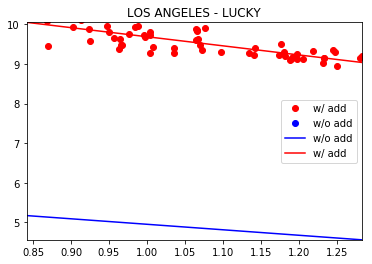

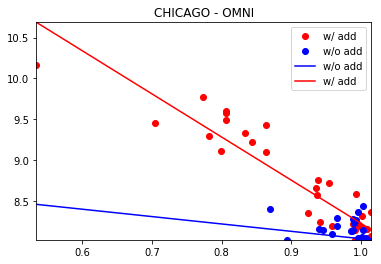

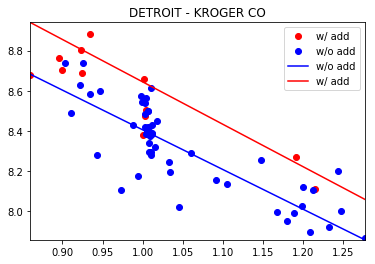

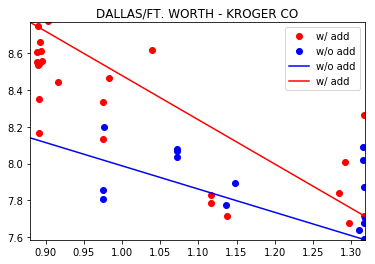

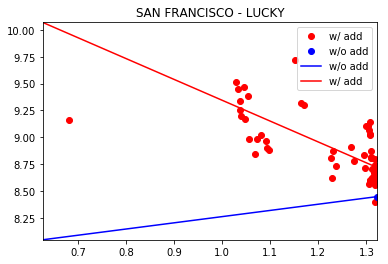

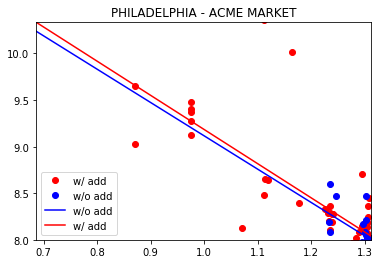

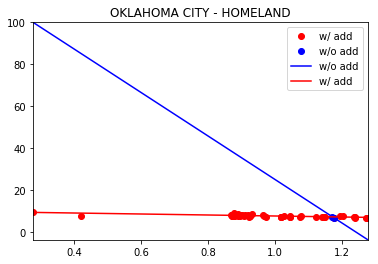

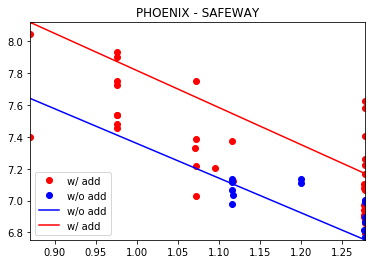

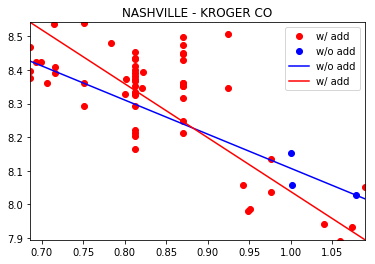

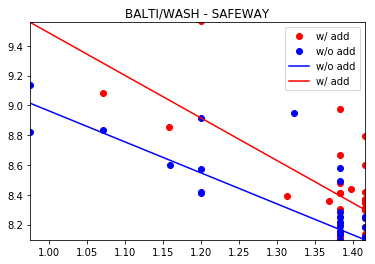

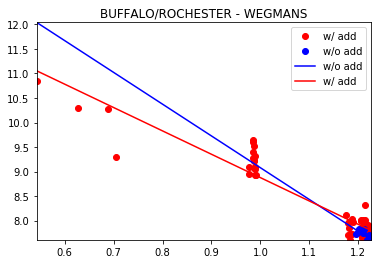

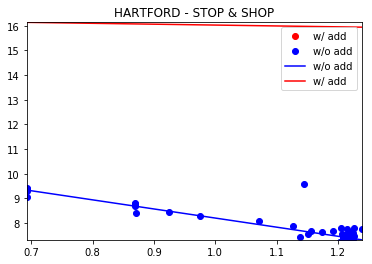

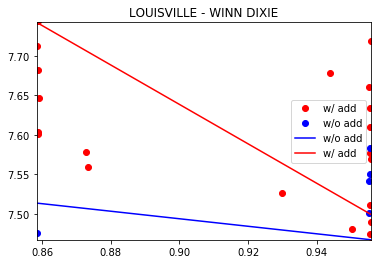

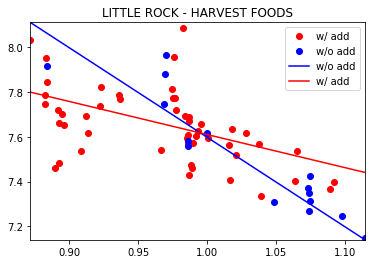

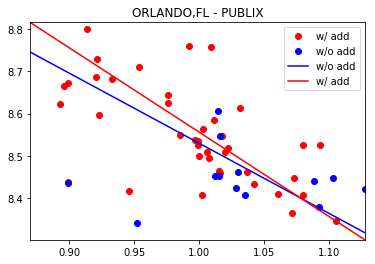

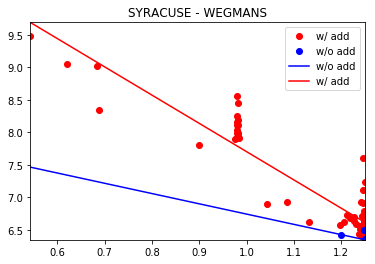

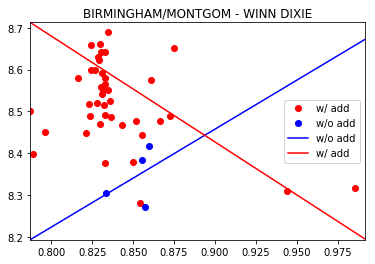

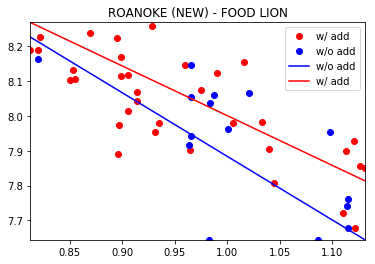

In [84]:
#Lets plot for some of the stores
for j in range (0,s,5):
    storename = unique_stores[j]
    plt.plot([X_df['store'] == storename],)
    a = X_df[X_df['store'] == storename].iloc[:,1:]
    a_disp = a[a['disp'] == 1]
    b = y_df[X_df['store'] == storename].iloc[:,1]
    b_disp = b[a['disp'] == 1]
    plt.plot(a_disp['log_price'],b_disp,'ro',label = 'w/ add')
    a_disp = a[a['disp'] != 1]
    b_disp = b[a['disp'] != 1]
    plt.plot(a_disp['log_price'],b_disp,'bo',label = 'w/o add')
    Xrange = np.linspace(min(a['log_price']),max(a['log_price']),100)

    No_ad  = Beta_post[0] + bi_post[0,j] + Xrange*(Beta_post[1]+bi_post[1,j])
    Yes_ad = No_ad + Beta_post[2] + bi_post[2,j] + Xrange*(Beta_post[3]+bi_post[3,j])
    plt.plot(Xrange, No_ad,'b',label = 'w/o add')
    plt.plot(Xrange, Yes_ad, 'r',label = 'w/ add')
    plt.legend()
    ymin = min(min(No_ad),min(Yes_ad))
    ymax = max(max(No_ad),max(Yes_ad))
    plt.ylim(ymin, ymax)
    plt.xlim(min(a['log_price']),max(a['log_price']))
    plt.title(storename)
    plt.show()